In [2]:
%matplotlib inline
from pycocotools.coco import COCO

import pandas as pd

# 단어사전 생성
from collections import Counter
import string
import re
import nltk
nltk.download('punkt')
import pickle

# torch
import torchvision
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
import torch.optim as optim
import torch.utils.data as data

# 시각화
import seaborn as sns

import numpy as np
import random
import skimage.io as io

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

[nltk_data] Downloading package punkt to /Users/shin-
[nltk_data]     ahreum/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## coco API 초기화

In [3]:
#data_dir='/Users/shin-ahreum/Documents/graduation_project/code/Mirror-DL/rawdataset/coco'
data_dir='../rawdataset/coco'
data_type='train2017'

# annotation 파일 위치
ann_file='{}/annotations/instances_{}.json'.format(data_dir, data_type)
coco = COCO(ann_file)           # pycocotools의 coco api 사용하여 annotation 가져오기

# caption 파일 위치
cap_file='{}/annotations/captions_{}.json'.format(data_dir, data_type)
coco_caps = COCO(cap_file)      # pycocotools의 coco api 사용하여 caption 가져오기

# 로컬 이미지 저장 경로
img_folder='{}/{}'.format(data_dir, data_type)

loading annotations into memory...
Done (t=6.30s)
creating index...
index created!
loading annotations into memory...
Done (t=0.34s)
creating index...
index created!


## 사용 가능 데이터 분리

사용 가능한 이미지 분리해서 필요한 캡션id, 이미지id, 이미지 이름, 캡션 데이터 가져오기

In [4]:
all_image_ids = coco.getImgIds()
img_ids = [] # 사용할 데이터들 id
no_anno_ids = [] # 사용하지 않을 데이터들 id

for idx in all_image_ids:
    annotations_ids = coco.getAnnIds(imgIds=idx, iscrowd=False)
    if len(annotations_ids) == 0 :
        no_anno_ids.append(idx)
    else :
        img_ids.append(idx)
        
print('전체 이미지 개수 : {}'.format(len(all_image_ids)))
print('사용가능 이미지 개수 : {}'.format(len(img_ids)))
print('사용불가 이미지 개수 : {}'.format(len(no_anno_ids)))

전체 이미지 개수 : 118287
사용가능 이미지 개수 : 117266
사용불가 이미지 개수 : 1021


In [7]:
image_ids = []
file_names = []
ids = []
captions = []

for i in range(len(img_ids)) :
    ann_ids = coco_caps.getAnnIds(imgIds = img_ids[i])
    anns = coco_caps.loadAnns(ann_ids)
    
    file_name = coco.loadImgs(img_ids[i])[0]['file_name']
    
    for j in range(len(anns)) :
        image_ids.append(anns[j]['image_id'])
        file_names.append(file_name)
        ids.append(anns[j]['id'])
        captions.append(anns[j]['caption'])

In [8]:
df = pd.DataFrame({'image_id':image_ids, 'file_name':file_names, 'caption':captions},
                          index = pd.Index(ids), columns = ['image_id','file_name','caption'])
df

,image_id,file_name,caption
770337,391895,000000391895.jpg,A man with a red helmet on a small moped on a ...
771687,391895,000000391895.jpg,Man riding a motor bike on a dirt road on the ...
772707,391895,000000391895.jpg,A man riding on the back of a motorcycle.
776154,391895,000000391895.jpg,A dirt path with a young person on a motor bik...
781998,391895,000000391895.jpg,A man in a red shirt and a red hat is on a mot...
...,...,...,...
283,475546,000000475546.jpg,The patrons enjoy their beverages at the bar.
5620,475546,000000475546.jpg,People having a drink in a basement bar.
5716,475546,000000475546.jpg,A group of friends enjoys a drink while sittin...
8002,475546,000000475546.jpg,Group of people drinking wine at a public loca...


In [9]:
def unique(l):
    if len(l)==len(set(l)):
        print("The List is Unique!")
        return True
    else:
        print("The List is Not Unique!")
        return False

unique(ids)

The List is Unique!


True

## 단어 임베딩 및 사전 구축

### 캡션 문장 소문자화 및 특수문자 제거

In [10]:
regex = re.compile('[%s]' % re.escape(string.punctuation))

def clean_text(text):
    text = str(text).strip()
    text = text.lower()
    return regex.sub("", text)

df['caption'] = df['caption'].apply(clean_text)
df['length'] = df['caption'].apply(lambda row: len(row.strip().split()))

In [11]:
df.head()

,image_id,file_name,caption,length
770337,391895,000000391895.jpg,a man with a red helmet on a small moped on a ...,14
771687,391895,000000391895.jpg,man riding a motor bike on a dirt road on the ...,12
772707,391895,000000391895.jpg,a man riding on the back of a motorcycle,9
776154,391895,000000391895.jpg,a dirt path with a young person on a motor bik...,28
781998,391895,000000391895.jpg,a man in a red shirt and a red hat is on a mot...,18


/var/folders/2t/y5m4cyqs2rl6j_09s0v3tmdh0000gn/T/ipykernel_10381/3539180373.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.displot(data=df, x='length', palette='mako', kind='kde', fill=True, aspect=4)


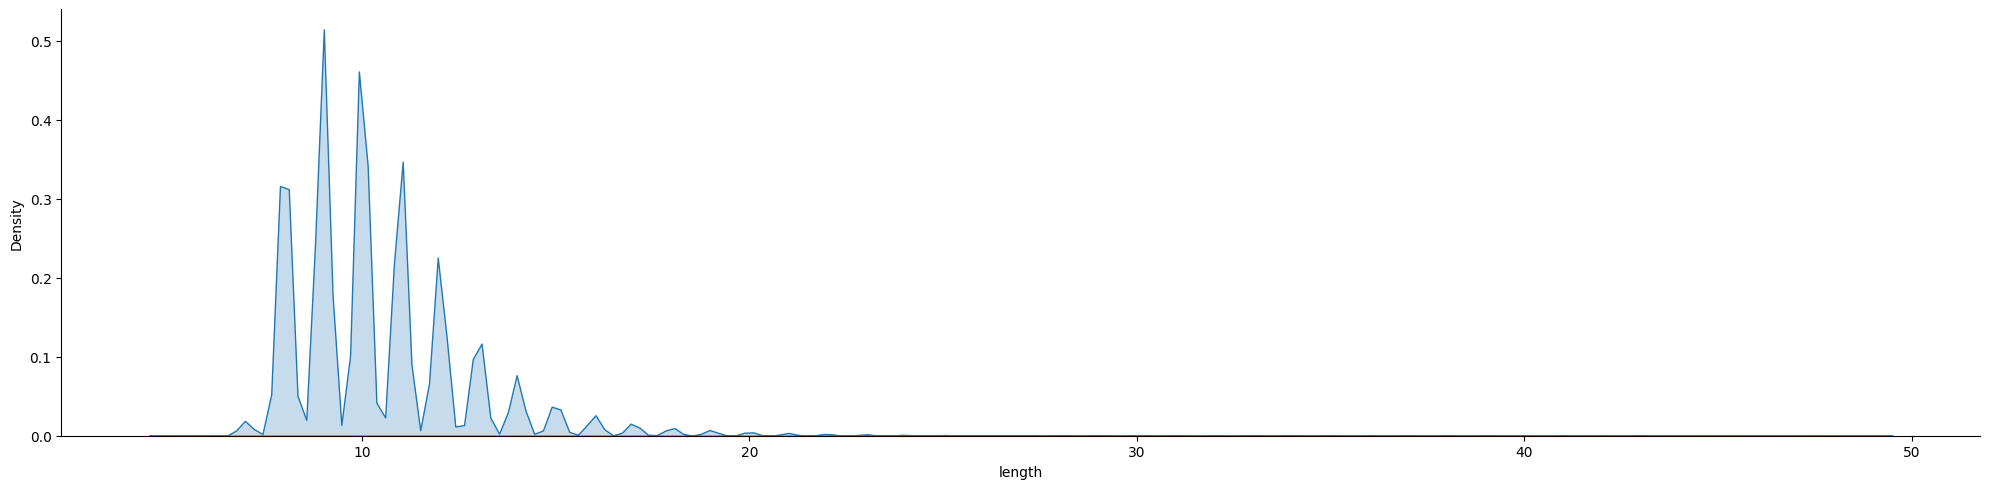

In [12]:
# 단어 개수의 분포 파악
sns.displot(data=df, x='length', palette='mako', kind='kde', fill=True, aspect=4)

In [13]:
# 각 단어의 빈도수 파악
captions = df['caption'].tolist()

word_freq = {}

for comment in captions:
    comment = comment.strip()
    for word in comment.split():
        if word not in word_freq:
            word_freq[word] = 0
        word_freq[word] += 1

dict(sorted(word_freq.items(), key=lambda item: item[1], reverse = True)[:10])

{'a': 971343,
 'on': 214017,
 'of': 201915,
 'the': 195875,
 'in': 182790,
 'with': 153478,
 'and': 139608,
 'is': 97452,
 'man': 73013,
 'to': 67397}

### caption으로 단어 사전 만들기 (단순)

In [14]:
captions[:5]

['a man with a red helmet on a small moped on a dirt road',
 'man riding a motor bike on a dirt road on the countryside',
 'a man riding on the back of a motorcycle',
 'a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloudwreathed mountains',
 'a man in a red shirt and a red hat is on a motorcycle on a hill side']

In [8]:
class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
    
    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
        
    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]
    
    def __len__(self):
        return len(self.word2idx)

In [10]:
vocab_path = './train_captions_vocab.pkl'
vocab = Vocabulary()            # 나오는 단어들을 저장
counter = Counter()             # caption들에 나오는 단어 리스트를 구성하고, 해당 단어가 몇번 나오는지 counter에 저장.
word_threshold = 3              # 단어가 4번 이상 나오면 vocab에 저장할 예정


vocab.add_word('<pad>')         # 문장의 길이를 맞춰주기 위한 토큰(모든 시퀀스를 특정 길이로 맞추기 위해 나머지 부분을 패딩 토큰으로 채움.)
vocab.add_word('<start>')       # 문장의 시작
vocab.add_word('<end>')         # 문장의 끝
vocab.add_word('<unk>')         # 모델이 학습 중에 처음 보는 단어를 나타내는 토큰


for i in range(len(captions)):
    caption = captions[i]
    
    tokens = nltk.tokenize.word_tokenize(caption)
    counter.update(tokens)
    
words = [word for word, cnt in counter.items() if cnt >= word_threshold]

for word in words:
    vocab.add_word(word)

with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)

In [11]:
len(vocab.word2idx)

13186

### bert imbedding vocab 구성

## Caption to Token

In [24]:
# 이미지와 문장들을 묶음
class cocoDataset(data.Dataset):
    def __init__(self, file_names, captions, vocab, transform=None) :
        self.captions = []
        self.img_folder = img_folder
        
        for i in range(len(captions)) :
            path = file_names[i]
            cap = captions[i]
            self.captions.append((path, cap))
            
        self.vocab = vocab
        self.transform = transform
    
    def __getitem__(self, index):
        vocab = self.vocab
        path = self.captions[index][0]
        caption = self.captions[index][1]
        
        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.tranform is not None:
            image = self.transform(image)
        
        tokens = nltk.tokenize.word_tokenize(caption)
        caption2token = []
        caption2token.append(vocab('<start>'))
        caption2token.extend([vocab(token) for token in tokens])
        caption2token.append(vocab('<end>'))
        target = torch.Tensor(caption2token)
        return image, target
    
    def __len__(self):
        return len(self.captions)

In [ ]:
# dataset이 
def collate_fn(data):
    # caption 길이로 데이터들 내림차순 정렬
    data.sort(key = lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)
    
    # 리스트 형태의 이미지들을 텐서 하나로 합침.
    images = torch.stack(images, 0)
    
    # 리스트 형태의 캡션들을 텐서 하나로 힙치기
    lengths = [len(caption) for caption in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    
    # 앞 부분의 내용을 패딩이 아닌 원래 토큰으로 채우기
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]